<a href="https://colab.research.google.com/github/Ness731/2022-2_Machine_Learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __LSTM Implementation__ in pytorch

# LSTM
RNN에서는 Long term dependency 문제를 해결하기 어렵다. 따라서 hidden state뿐만 아니라 **cell state**라는 새로운 개념을 도입한 **LSTM**이 고안되었다. 

**cell state**는 hidden state와는 달리 시점이 지날수록 이전 정보가 희미해지는 것이 아니라, 값을 온전히 보존해주는 역할을 한다. 즉, 모델의 **장기기억**에 해당한다. 긴 시간 동안의 정보를 기억하는 것은 모델의 기본적인 행동이어야지, 모델이 그것을 배우기 위해서 몸부림치지 않도록 한 것이다.

- **Cell state** : **모델의 장기기억(Long term memory)**에 해당하는 부분. LSTM 모델에만 있는 요소이다.
- **Hidden state** : **모델의 작업기억(Working memory)**에 해당하는 부분, LSTM과 RNN 공통적으로 있는 요소이다.

### __개발환경 구축__

In [ ]:
# Library import
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
import math

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [ ]:
# Dataset load
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### __LSTM cell implementation__

### Cell state (c)

**cell state**는 block 내부의 여러 간선 중 맨 위에 수평으로 그어진 선에 해당한다. cell state에는 input 값을 직접 적용하지 않고 activation function을 반드시 거친다. 

### Hidden state (h)

hidden state는 block 내부의 여러 간선 중 맨 아래에 수평으로 그어진 선에 해당한다. hidden state는 cell state와는 다르게 input을 직접 적용할 수 있으며, 이전 시점의 cell state값을 사용할 수 있다.

### Gate

LSTM의 block에는 **cell state에 정보를 추가하는 작업을 통제**하는 **gate**가 총 3개 존재한다.

- f : forget gate
- i : input gate
- o : output gate

### Sigmoid function

시그모이드 함수의 정의역은 [0, 1]이며, 이는 각 컴포넌트가 정보를 얼마나 전달해야 하는지를 의미한다. 0에 가까울수록 반영하지 않는 것이며, 1에 가까울수록 모든 정보를 반영한다는 의미이다.

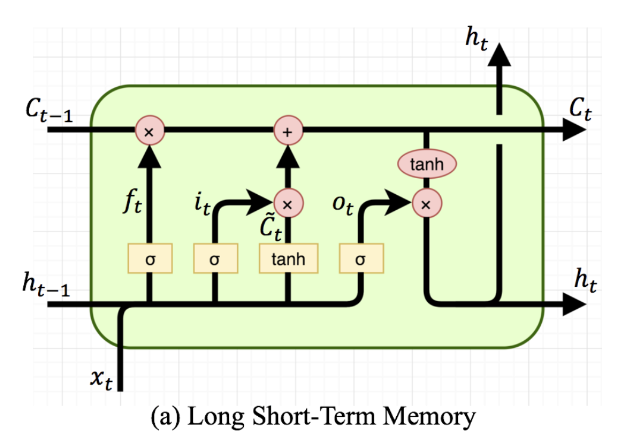

In [ ]:
class LSTM(nn.Module):
  
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTM, self).__init__()

    # hyper parameter init
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # layer init
    self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias) # input(x_t) -> hidden(h_t-1)
    self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias) # hidden(h_t-1) -> hidden(h_t)
    self.c2c = Tensor(hidden_size * 3) # cell(c_t-1) -> cell(c_t)
    self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        # 현재 시점 = t
        h_t, c_t = hidden
        
        x_t = x.view(-1, x.size(1))
        
        gates = self.x2h(x_t) + self.h2h(h_t)

        gates = gates.squeeze()
        
        # 게이트 생성을 위해 텐서를 나누는 작업
        c2c = self.c2c.unsqueeze(0)
        # 3개로 나눔 : input, out, forget gate와 합쳐지는 cell state를 의미
        ci, cf, co = c2c.chunk(3,1)
        # gate를 4개로 나눔 : 3 type of gate + cell gate를 의미
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        # 실제 작업
        ingate = torch.sigmoid(ingate + ci * cx)
        forgetgate = torch.sigmoid(forgetgate + cf * cx)
        cellgate = forgetgate*cx + ingate* torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate+ co*cellgate)
        
        hm = outgate * F.tanh(cellgate)
        return (hm, cellgate)